# ACI ASSIGNMENT  
  
## Student survey (engineering.csv) - **Bayesian Belief Network**  

**ACI Group 011**
  
Karthik S R **(2020fc04065)**  
Swetha K **(2020fc04678)**  
Rangineni Saisasidhar **(2020fc04066)**  
Shruti Singh **(2020fc04067)**    
Karthik T **(2020fc04198)**

We have been gathering vital data from engineering students as part of a thorough investigation of the effect of 40-100 on people's success. We ask the following extremely objective questions in a totally voluntary survey that all students are obliged to complete:
* Do you attend parties? [party: yes/no]
* Are you smart? [smart: yes/no]
* Are you innovative? [innovative: yes/no]
* Will you be up-to-date to finish your assignments? [assignment: yes/no]
* Do you have a laptop? [laptop: yes/no]
* Does your project succeed between 40-100? [project: yes/no]
* Have you derived your project goal successfully? [goal: yes/no]
* Do you feel happy now? [happy: yes/no]  

You can get the comma-separated survey results from following line.  
  
The columns in engineering.csv relates to each question (random variable) in the order **party, smart, innovative, assignment, laptop, project, goal, and happy**.  The entries are either zero, corresponding to No response, or one, corresponding to a Yes response. The following complete set of conditional relationships are obtained after consulting a behavioural psychologist: 
* Assignment depends only on Party and Smart
* Laptop depends only on Smart and Innovative
* Project depends only on Smart and Innovative
* Goal depends only on Assignment and Project
* Happy depends only on Party, laptop, and goal  
  
**Question 1: Python**   
* Construct a Bayesian Belief Network for the given data.  
* Use appropriate methods to predict the following:  
    * Predict the probability of a graduate happy.  
    * Predict the probability of student’s success in their project  

Import required libraries

In [1]:
!pip install pybbn

  Created wheel for pybbn: filename=pybbn-3.2.1-py3-none-any.whl size=39725 sha256=caf57679924458486694b19925affa1b9a40c66bc6b4e2c13b5d49853e7da6b1
  Stored in directory: /root/.cache/pip/wheels/a8/64/55/b52530d41fe7c9ae501ddd7c06f3122ceb5f15921680f0371b
Successfully built pybbn


import the data file to pandas dataframe

In [2]:
import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs

# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
from pybbn.pptc.moralizer import Moralizer

from IPython.core.display import display, HTML

from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Set Pandas options to display more columns
pd.options.display.max_columns=50

# Read in the engineering data csv
df=pd.read_csv('../input/engineering-student-survey/engineering.csv', encoding='utf-8', header=None, names=['party', 'smart', 'innovative', 'assignment', 'laptop', 'project', 'goal', 'happy'])

In [4]:
df = df.drop_duplicates()

Check for null values

In [5]:
df.isna().sum() 

party         0
smart         0
innovative    0
assignment    0
laptop        0
project       0
goal          0
happy         0
dtype: int64

In [6]:
df1=df.copy()

No null values let us make the 0s and 1s as Yes and No to make it categorical data

In [7]:
for column_names in df.columns:
    df[column_names] = df[column_names].apply(lambda x: 'Yes' if x == 1 else 'No')

Print 5 rows

In [8]:
df.head()

,party,smart,innovative,assignment,laptop,project,goal,happy
0,No,Yes,Yes,Yes,Yes,No,No,No
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes
2,No,Yes,Yes,Yes,Yes,Yes,Yes,No
3,No,Yes,Yes,Yes,No,Yes,Yes,Yes
4,Yes,Yes,No,No,Yes,Yes,Yes,Yes


check shape of dataframe

In [9]:
df.shape

(195, 8)

Describe the categorical data

In [10]:
df.describe()

,party,smart,innovative,assignment,laptop,project,goal,happy
count,195,195,195,195,195,195,195,195
unique,2,2,2,2,2,2,2,2
top,Yes,Yes,Yes,Yes,No,Yes,No,Yes
freq,98,104,105,101,101,98,106,98


In [11]:
df.head()

,party,smart,innovative,assignment,laptop,project,goal,happy
0,No,Yes,Yes,Yes,Yes,No,No,No
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes
2,No,Yes,Yes,Yes,Yes,Yes,Yes,No
3,No,Yes,Yes,Yes,No,Yes,Yes,Yes
4,Yes,Yes,No,No,Yes,Yes,Yes,Yes


Function to calculate probabilities for upto 3 parent nodes

In [12]:
def probs(data, child, parent1=None, parent2=None, parent3=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            if parent2!=None:
                if parent3!=None:
                    # Caclucate probabilities
                    prob=pd.crosstab([data[parent1],data[parent2], data[parent3]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
                else:
                    # Caclucate probabilities
                    prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()                
    else: print("Error in Probability Frequency Calculations")
    return prob  

Construct a Bayesian Belief Network for the given data.

create the BBN nodes

In [13]:
# Create nodes by using our earlier function to automatically calculate probabilities
party = BbnNode(Variable(0, 'party', ['Yes', 'No']), probs(df, child='party'))
smart = BbnNode(Variable(1, 'smart', ['Yes', 'No']), probs(df, child='smart'))
innovative = BbnNode(Variable(2, 'innovative', ['Yes', 'No']), probs(df, child='innovative'))
assignment = BbnNode(Variable(3, 'assignment', ['Yes', 'No']), probs(df, child='assignment', parent1='party', parent2='smart'))
laptop = BbnNode(Variable(4, 'laptop', ['Yes', 'No']), probs(df, child='laptop',parent1='smart',parent2='innovative'))
project = BbnNode(Variable(5, 'project', ['Yes', 'No']), probs(df, child='project', parent1='smart',parent2='innovative'))
goal = BbnNode(Variable(6, 'goal', ['Yes', 'No']), probs(df, child='goal',parent1='assignment',parent2='project'))
happy = BbnNode(Variable(7, 'happy', ['Yes', 'No']), probs(df, child='happy',parent1='party',parent2='laptop', parent3='goal'))

join the BBN nodes into a network

In [14]:
# Create Network
bbn = Bbn() \
    .add_node(party) \
    .add_node(smart) \
    .add_node(innovative) \
    .add_node(assignment) \
    .add_node(laptop) \
    .add_node(project) \
    .add_node(goal) \
    .add_node(happy) \
    .add_edge(Edge(party,assignment, EdgeType.DIRECTED)) \
    .add_edge(Edge(smart, assignment, EdgeType.DIRECTED)) \
    .add_edge(Edge(smart, laptop, EdgeType.DIRECTED)) \
    .add_edge(Edge(innovative, laptop, EdgeType.DIRECTED)) \
    .add_edge(Edge(smart, project,  EdgeType.DIRECTED)) \
    .add_edge(Edge(innovative, project, EdgeType.DIRECTED)) \
    .add_edge(Edge(assignment, goal, EdgeType.DIRECTED)) \
    .add_edge(Edge(project, goal, EdgeType.DIRECTED)) \
    .add_edge(Edge(party, happy,  EdgeType.DIRECTED)) \
    .add_edge(Edge(laptop, happy, EdgeType.DIRECTED)) \
    .add_edge(Edge(goal, happy, EdgeType.DIRECTED))

print(bbn)

0|party|Yes,No
1|smart|Yes,No
2|innovative|Yes,No
3|assignment|Yes,No
4|laptop|Yes,No
5|project|Yes,No
6|goal|Yes,No
7|happy|Yes,No
0->3
1->3
1->4
2->4
1->5
2->5
3->6
5->6
0->7
4->7
6->7


plot the Bayesian Belief Network

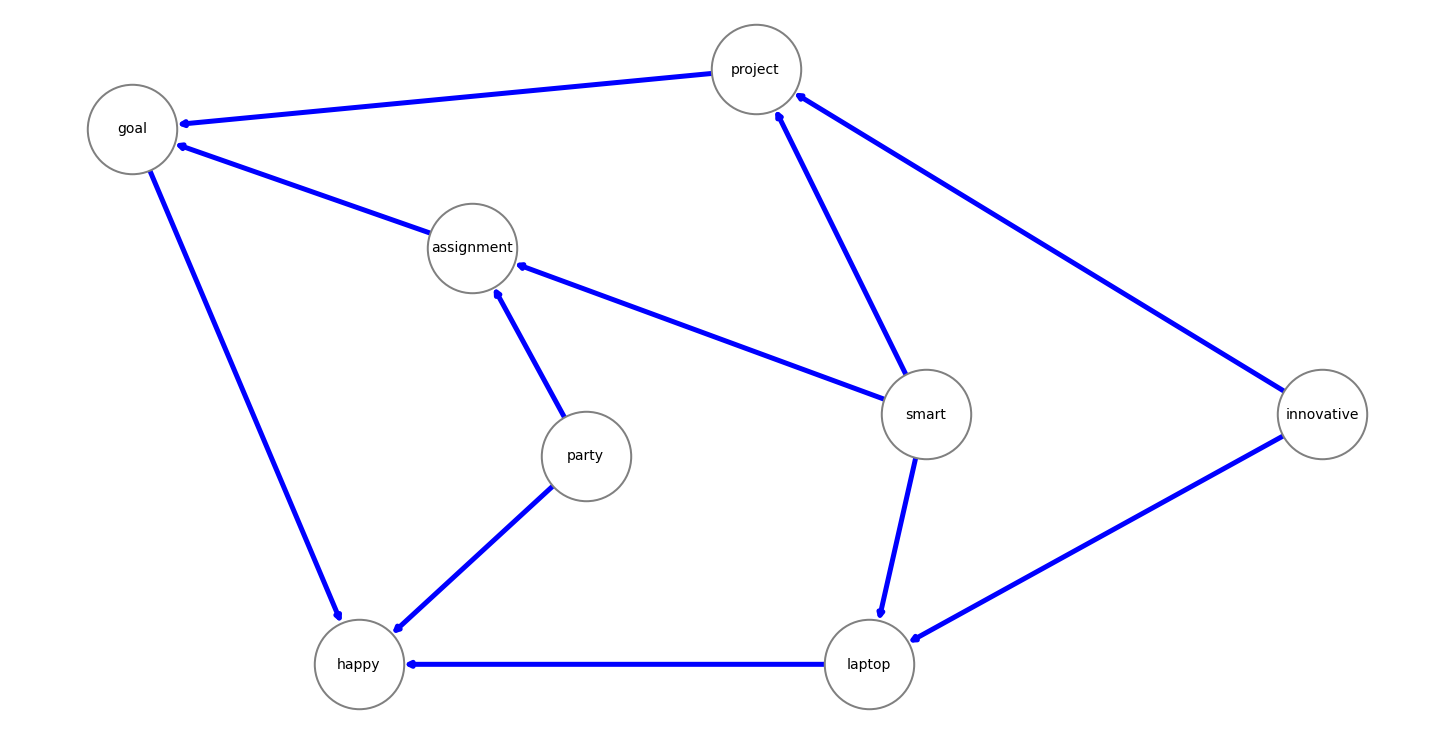

In [15]:
# Set node positions
pos = {0: (-3, -5), 1: (3, 2), 2: (10, 2), 3: (-5, 30), 4: (2, -40), 5: (0, 60), 6: (-11, 50), 7: (-7, -40)}

# Set options for graph looks
options = {
    "font_size": 14,
    "node_size": 8000,
    "node_color": "white",
    "edgecolors": "grey",
    "edge_color": "blue",
    "linewidths": 2,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gcf()
ax.set_size_inches(20,10)  
plt.axis("off")
plt.show()

Convert the network into a join tree to find other probabilities

In [16]:
#  convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

Function for printing marginal probabilities

In [17]:
# Define a function for printing marginal probabilities
def print_probs():
    html = ['<table width=100% style="border: 1px solid black">']
    html.append('<tr style="border: 1px solid black">')
    html.append('<td style= "text-align: center;border: 1px solid black" rowspan="2"><strong>{0}</strong></td>'.format("Node"))
    html.append('<td style= "text-align: center;border: 1px solid black" colspan="2"><strong>{0}</strong></td>'.format("Probability"))
    html.append("</tr>")
    html.append('<tr style="border: 1px solid black">')
    html.append('<td style= "text-align: center;border: 1px solid black"><strong>{0}</strong></td>'.format("Yes"))
    html.append('<td style= "text-align: center;border: 1px solid black"><strong>{0}</strong></td>'.format("No"))
    html.append("</tr>")
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        html.append('<tr style="border: 1px solid black">')
        html.append('<td style="border: 1px solid black">{0}</td>'.format(str(node).split("|")[1]))
        potentialStr = str(potential).replace("=", "|").replace(" ","|").replace("\n", "|").split("|")
        html.append('<td style="border: 1px solid black">{0}</td>'.format(potentialStr[2]))
        html.append('<td style="border: 1px solid black">{0}</td>'.format(potentialStr[5]))
        html.append("</tr>")  
    html.append("</table>")
    display(HTML(''.join(html)))


print marginal probabilities

In [18]:
# Use the above function to print marginal probabilities
print_probs()

add evidence of events that happened so probability distribution can be recalculated

In [19]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.unobserve_all()
    join_tree.set_observation(ev)

Predict the probability of a graduate happy

In [20]:
# Use above function to add evidence Students being happy
evidence('ev1', 'happy', 'Yes', 1.0)
# Print marginal probabilities
print_probs()

Predict the probability of student’s success in their project

In [21]:
# Use above function to add evidence about Project being successful
evidence('ev2', 'project', 'Yes', 1.0)

# Print marginal probabilities
print_probs()


**Question 2: Prolog**
* Use Any of the decision tree algorithms to build a decision tree for the given data 
    * Create rules from the decision tree. 
    * Code the rules into a Prolog Knowledge base.


In [22]:
# Spliting the input columns and the output column
# Building Tree based model on data
X = df1.drop(['happy'], axis = 1)
Y = df1['happy']
Model = DecisionTreeClassifier(max_depth=7, random_state=1234) 
Classifier = Model.fit(X,Y)
text_representation = tree.export_text(Classifier,feature_names=list(X.columns))
print(text_representation)

|--- party <= 0.50
|   |--- goal <= 0.50
|   |   |--- project <= 0.50
|   |   |   |--- smart <= 0.50
|   |   |   |   |--- assignment <= 0.50
|   |   |   |   |   |--- innovative <= 0.50
|   |   |   |   |   |   |--- laptop <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- laptop >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- innovative >  0.50
|   |   |   |   |   |   |--- laptop <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- laptop >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- assignment >  0.50
|   |   |   |   |   |--- laptop <= 0.50
|   |   |   |   |   |   |--- innovative <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- innovative >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- laptop >  0.50
|   |   |   |   |   |   |--- innovative <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- innovati

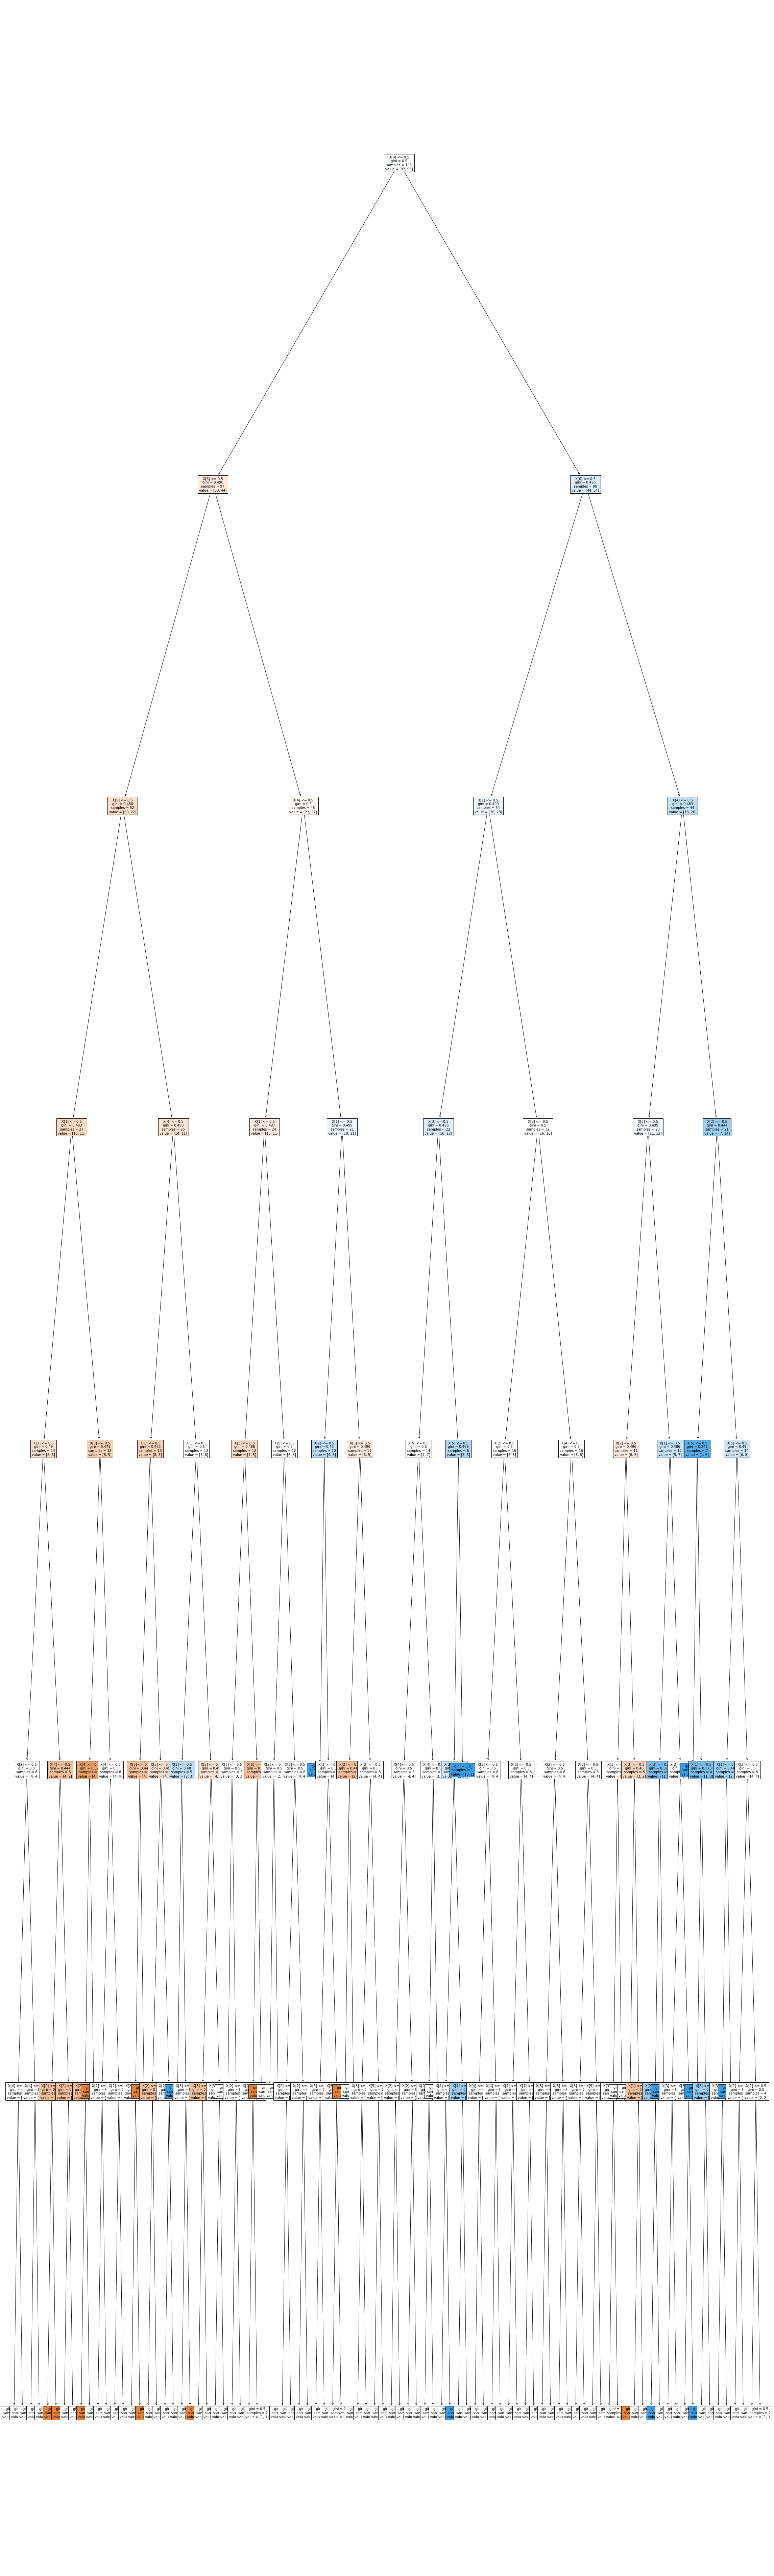

In [23]:
fig = plt.figure(figsize=(40,140))
tree_ = tree.plot_tree(Classifier, filled=True, fontsize=10)

In [24]:
X = X.drop_duplicates()
print(X.shape)

(111, 7)


## Working on Decission Tree rules to if conditions:

Here we show the extracted rules from the decission tree and their equivalant prolog rules.

    |--- party <= 0.50
    |   |--- goal <= 0.50
    |   |   |--- laptop >  0.50
    |   |   |   |--- project >  0.50
    |   |   |   |   |--- smart <= 0.50
    |   |   |   |   |   |--- innovative <= 0.50
    |   |   |   |   |   |   |--- class: 1


#### if party == no and goal == no and laptop == yes and project == yes and smart == no and innovative == no then happy = yes

#### Here we are using following variables to provide input
A - party, B- smart, C - innovative, D - assignment, E - laptop, F - project, G - goal 
In order to check the value of "no" for a attribute, negate of the varaiable is checked. So above the decission tree rule is converted as follows

#### (not(party(A)), (not(goal(G)), laptop(E), project(F), not(smart(B)), not(innovative(C)).

#### Applying same approach to convert all 'Class 1'  rules:

    |   |--- goal >  0.50
    |   |   |--- laptop <= 0.50
    |   |   |   |--- innovative >  0.50
    |   |   |   |   |--- smart <= 0.50
    |   |   |   |   |   |--- project <= 0.50
    |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |--- project >  0.50
    |   |   |   |   |   |   |--- assignment <= 0.50
    |   |   |   |   |   |   |   |--- class: 1
#### (not(party(A)), goal(G), not(laptop(E)), innovative(C), not(smart(B)), not(project(F)).
#### (not(party(A)), goal(G), not(laptop(E)), innovative(C), not(smart(B)), project(F),not(assignment(D)).


    |   |   |--- laptop >  0.50
    |   |   |   |--- smart <= 0.50
    |   |   |   |   |--- innovative <= 0.50
    |   |   |   |   |   |--- class: 1
    |   |   |   |   |--- innovative >  0.50
    |   |   |   |   |   |--- project <= 0.50
    |   |   |   |   |   |   |--- assignment <= 0.50
    |   |   |   |   |   |   |   |--- class: 1

#### (not(party(A)), goal(G), laptop(E), not(smart(B)), not(innovative(C)).
#### (not(party(A)), goal(G), laptop(E), not(smart(B)), innovative(C),  not(project(F)),not(assignment(D)).


    |--- party >  0.50
    |   |--- goal <= 0.50
    |   |   |--- laptop <= 0.50
    |   |   |   |--- project <= 0.50
    |   |   |   |   |--- smart <= 0.50
    |   |   |   |   |   |--- assignment >  0.50
    |   |   |   |   |   |   |--- innovative <= 0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |   |--- innovative >  0.50
    |   |   |   |   |   |   |   |--- class: 1

#### party(A), (not(goal(G)), not(laptop(E)), not(project(F)), not(smart(B)),  assignment(D).


    |   |   |   |   |--- smart >  0.50
    |   |   |   |   |   |--- assignment <= 0.50
    |   |   |   |   |   |   |--- innovative <= 0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |   |--- innovative >  0.50
    |   |   |   |   |   |   |   |--- class: 1
#### party(A), (not(goal(G)), not(laptop(E)), not(project(F)), smart(B),  not(assignment(D)).

    |   |   |   |--- project >  0.50
    |   |   |   |   |--- innovative <= 0.50
    |   |   |   |   |   |--- assignment >  0.50
    |   |   |   |   |   |   |--- class: 1
#### party(A), (not(goal(G)), not(laptop(E)), project(F), not(innovative(C)),  assignment(D).


    |   |   |--- laptop >  0.50
    |   |   |   |--- assignment <= 0.50
    |   |   |   |   |--- innovative <= 0.50
    |   |   |   |   |   |--- project <= 0.50
    |   |   |   |   |   |   |--- smart <= 0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |   |--- smart >  0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |--- project >  0.50
    |   |   |   |   |   |   |--- class: 1

#### party(A), (not(goal(G)), laptop(E), not(assignment(D)), not(innovative(C)).


    |   |   |   |   |--- innovative >  0.50
    |   |   |   |   |   |--- smart >  0.50
    |   |   |   |   |   |   |--- project <= 0.50
    |   |   |   |   |   |   |   |--- class: 1
#### party(A), (not(goal(G)), laptop(E), not(assignment(D)), innovative(C),smart(B),not(project(F)).


    |   |   |   |--- assignment >  0.50
    |   |   |   |   |--- smart <= 0.50
    |   |   |   |   |   |--- project <= 0.50
    |   |   |   |   |   |   |--- innovative >  0.50
    |   |   |   |   |   |   |   |--- class: 1
#### party(A), (not(goal(G)), laptop(E), assignment(D), not(smart(B)),not(project(F)),innovative(C).


    |   |   |   |   |   |--- project >  0.50
    |   |   |   |   |   |   |--- class: 1
#### party(A), (not(goal(G)), laptop(E), assignment(D), not(smart(B)),project(F).

    |   |   |   |   |--- smart >  0.50
    |   |   |   |   |   |--- innovative >  0.50
    |   |   |   |   |   |   |--- project >  0.50
    |   |   |   |   |   |   |   |--- class: 1
#### party(A), (not(goal(G)), laptop(E), assignment(D), smart(B),innovative(C),project(F).


    |   |--- goal >  0.50
    |   |   |--- laptop <= 0.50
    |   |   |   |--- assignment <= 0.50
    |   |   |   |   |--- project <= 0.50
    |   |   |   |   |   |--- innovative <= 0.50
    |   |   |   |   |   |   |--- class: 1
#### party(A), goal(G), not(laptop(E)), not(assignment(D)), not(project(F)),not(innovative(C)).



    |   |   |   |   |--- project >  0.50
    |   |   |   |   |   |--- smart <= 0.50
    |   |   |   |   |   |   |--- innovative <= 0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |   |--- innovative >  0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |--- smart >  0.50
    |   |   |   |   |   |   |--- innovative <= 0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |   |--- innovative >  0.50
    |   |   |   |   |   |   |   |--- class: 1
#### party(A), goal(G), not(laptop(E)), not(assignment(D)), project(F).


    |   |   |   |--- assignment >  0.50
    |   |   |   |   |--- innovative <= 0.50
    |   |   |   |   |   |--- project <= 0.50
    |   |   |   |   |   |   |--- smart <= 0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |   |--- smart >  0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |--- project >  0.50
    |   |   |   |   |   |   |--- smart <= 0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |   |--- smart >  0.50
    |   |   |   |   |   |   |   |--- class: 1
#### party(A), goal(G), assignment(D), not(innovative(C)).

    |   |   |   |   |--- innovative >  0.50
    |   |   |   |   |   |--- smart >  0.50
    |   |   |   |   |   |   |--- project <= 0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |   |--- project >  0.50
    |   |   |   |   |   |   |   |--- class: 1
#### party(A), goal(G), assignment(D), innovative(C),smart(B).


    |   |   |--- laptop >  0.50
    |   |   |   |--- innovative <= 0.50
    |   |   |   |   |--- project <= 0.50
    |   |   |   |   |   |--- class: 1
#### party(A), goal(G), laptop(E), not(innovative(C)),not(project(F)).

    |   |   |   |   |--- project >  0.50
    |   |   |   |   |   |--- assignment <= 0.50
    |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |--- assignment >  0.50
    |   |   |   |   |   |   |--- smart <= 0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |   |--- smart >  0.50
    |   |   |   |   |   |   |   |--- class: 1
#### party(A), goal(G), laptop(E), project(F).

    |   |   |   |--- innovative >  0.50
    |   |   |   |   |--- assignment <= 0.50
    |   |   |   |   |   |--- smart <= 0.50
    |   |   |   |   |   |   |--- project <= 0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |   |--- project >  0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |--- smart >  0.50
    |   |   |   |   |   |   |--- project <= 0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |   |--- project >  0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |--- assignment >  0.50
    |   |   |   |   |   |--- smart <= 0.50
    |   |   |   |   |   |   |--- project <= 0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |   |--- project >  0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |--- smart >  0.50
    |   |   |   |   |   |   |--- project <= 0.50
    |   |   |   |   |   |   |   |--- class: 1
    |   |   |   |   |   |   |--- project >  0.50
    |   |   |   |   |   |   |   |--- class: 1
#### party(A), goal(G), laptop(E), innovative(C).

### Prologue Code

    party(yes).
    smart(yes).
    innovative(yes).
    assignment(yes).
    laptop(yes).
    project(yes).
    goal(yes).


    is_happy(A,B,C,D,E,F,G) :-
        (
            (not(party(A)), not(smart(B)), not(innovative(C)), laptop(E),  project(F), not(goal(G)) );
            (not(party(A)), not(smart(B)), innovative(C), not(assignment(D)), laptop(E),   not(project(F)), goal(G));
            (not(party(A)), not(smart(B)), goal(G), not(laptop(E)), innovative(C), (not(project(F)); (project(F), not(assignment(D)))));
            (not(party(A)), not(smart(B)), not(innovative(C)), laptop(E), goal(G) );
            (party(A), not(goal(G)), not(laptop(E)), not(project(F)), not(smart(B)),  assignment(D));
            (party(A), not(goal(G)), not(laptop(E)), not(project(F)), smart(B),  not(assignment(D)));
            (party(A), not(goal(G)), not(laptop(E)), project(F), not(innovative(C)),  assignment(D));
            (party(A), not(goal(G)), laptop(E), not(assignment(D)), not(innovative(C)));
            (party(A), not(goal(G)), laptop(E), not(assignment(D)), innovative(C),smart(B),not(project(F)));
            (party(A), not(goal(G)), laptop(E), assignment(D), not(smart(B)),not(project(F)),innovative(C));
            (party(A), not(goal(G)), laptop(E), assignment(D), not(smart(B)),project(F));
            (party(A), not(goal(G)), laptop(E), assignment(D), smart(B),innovative(C),project(F));
            (party(A), goal(G), not(laptop(E)), not(assignment(D)), not(project(F)),not(innovative(C)));
            (party(A), goal(G), not(laptop(E)), not(assignment(D)), project(F));
            (party(A), goal(G), assignment(D), not(innovative(C)));
            (party(A), goal(G), assignment(D), innovative(C),smart(B));
            (party(A), goal(G), laptop(E), not(innovative(C)),not(project(F)));
            (party(A), goal(G), laptop(E), project(F));
            (party(A), goal(G), laptop(E), innovative(C))
        ).



### Testing Procedure    
Syntax for testing the inputs:


**is_happy(Party,Smart,Innovative,Assignment,Laptop,Project,Goal)**


And for Variables Party,Smart,Innovative,Assignment,Laptop,Project,Goal: the input can be **yes/no**


### Sample testing:  

?- is_happy(yes,no,yes,no,yes,no,yes)

<b>true</b>

?- is_happy(no,yes,no,yes,yes,yes,yes)

<b>false</b>

?- is_happy(yes,no,yes,no,yes,no,no)

<b>false</b>


**Input Test**  
run_test :-   
write('Survey Details:  '),  
write('Enter Party: <yes/no>?'), read(A),  
write('Enter Smart: <yes/no>?'), read(B),  
write('Enter Innovative: <yes/no>?'), read(C),  
write('Enter Assignment: <yes/no>?'), read(D),  
write('Enter Laptop: <yes/no>?'), read(E),  
write('Enter Project: <yes/no>?'), read(F),  
write('Enter Goal: <yes/no>?'), read(G),  
write('The Student is happy:\n'),  
is_happy(A,B,C,D,E,F,G).  
